In [2]:
import pandas as pd
import numpy as np
from app.modules import prep_data, train_model, select_features, build_dset, build_LSTM, build_BLSTM, build_AttentiveBLSTM
from app.modules import gen_test_df, gen_importance_df
from app.modules.lstm import save_model, series_to_supervised, load_model, get_lime_df, train_model, prep_data

from app.api import GoogleTrends
import datetime as dt
import time

import lime
import lime.lime_tabular
from keras.callbacks import EarlyStopping

## PLOTS

In [3]:
from turtle import width
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import lime
import lime.lime_tabular

# To load filtered test predictions
def filter_test_df(test_df, ticker, model_id, pred_scope):

    test_df = test_df.query('Scope==@pred_scope & Ticker==@ticker & Model==@model_id')
    test_df = test_df[['Observed', 'Predicted']]

    return test_df.sort_index()


def plot_model_test(filtered_df: pd.DataFrame, px_theme: str ='plotly_dark'):

    fig = px.line(
            filtered_df,
            x=filtered_df.index, 
            y=filtered_df.columns,
            template=px_theme,
            labels={
                    'variable': ''
                },
            )
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    fig.update_yaxes(title_text = 'Close Price')
    fig.update_layout(
        yaxis_tickformat = '$',
        title={
            #'text': "Model Performance",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25)
            },
        )
    fig.update_traces(hovertemplate='%{y:$,.2f}')
    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(
        title_text = 'Date',
        rangeslider_visible = True
        )
    fig.update_layout(width=750, height=500)
    return fig


def plot_importance(importance_df: pd.DataFrame, px_theme: str ='plotly_dark'):

    fig = go.Figure()
    fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='DarkGrey')

    metrics_list = list(importance_df['Metric'].unique())

    for metric in metrics_list:
        vis = metric == 'mae'
        mdf = importance_df[importance_df['Metric']==metric]

        mdf = mdf.sort_values('Importance').tail(5)
        fig.add_trace(
            go.Bar(
                orientation='h', 
                x = mdf['Importance'],
                y = mdf['Feature'],
                name = metric, 
                visible=vis
            )
        )
                
    buttons = []

    for i, metric in enumerate(metrics_list):
        args = [False] * len(metrics_list)
        args[i] = True
        
        button = dict(
                    label = metric.upper(),
                    method = "update",
                    args=[{"visible": args}])
        
        buttons.append(button)
        
    fig.update_layout(
        updatemenus=[dict(
                        active=0,
                        type="buttons",
                        direction = "left",
                        buttons=buttons,
                        x = 1,
                        y = 1,
                        xanchor = 'left',
                        yanchor = 'bottom'
                    )], 
        autosize=True,
    )
    fig.update_layout(
        title={
            'text': "Error Perturbation",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
            #family="Courier New, monospace",
            size=25
            )
            },
        template=px_theme
    )

    fig.update_yaxes(tickmode='linear')
    #fig.update_layout(updatemenus=[dict(font=dict(color='gray',), bgcolor='black')])
    fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')
    fig.update_layout(width=750, height=500)

    return fig

def get_lime_df(model, model_id, X_train, X_test, dsets, test_dates, ticker, scope, yscaler):

    explainer = lime.lime_tabular.RecurrentTabularExplainer(
                                            X_train,
                                            feature_names=list(dsets[ticker + '-USD'].columns),
                                            verbose=True,
                                            mode='regression',
                                            discretize_continuous=False
                                            )

    lime_dfs = []
    for i in range(len(test_dates)):
        exp = explainer.explain_instance(X_test[i], model.predict)
        lime_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'LIME Weight'])
        lime_df['Predicted Close t+'+scope[0]] = yscaler.inverse_transform(lime_df['LIME Weight'].abs().values.reshape(-1,1))[:,0] * (lime_df['LIME Weight'].values//lime_df['LIME Weight'].abs().values)
        lime_df['Date'] = test_dates[i]
        lime_df['Model'] = model_id
        lime_df['Ticker'] = ticker
        lime_df['Scope'] = scope
        lime_dfs.append(lime_df)
    lime_df = pd.concat(lime_dfs)
    lime_df['LIME Weight'] = yscaler.inverse_transform(lime_df['LIME Weight'].abs().values.reshape(-1,1)) * (lime_df['LIME Weight'].values//lime_df['LIME Weight'].abs().values)
        
    lime_df.rename(columns={'Date': 'Date_dt'}, inplace=True)
    lime_df['Date'] = lime_df['Date_dt'].dt.date.apply(lambda x: str(x))
    return lime_df

def plot_lime(lime_df):

    fig = px.bar(
        lime_df, 
        x='LIME Weight', 
        y='Feature',
        animation_frame='Date',
        orientation='h', 
        color='LIME Weight', 
        template='plotly_dark',
        title="LIME - Top Features' Effect on Close t+1",
        color_continuous_scale='viridis',
        )
    fig.update_layout(
            xaxis_tickformat = '$',
            title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(
                #family="Courier New, monospace",
                size=25)
                },
            )
    fig.update_traces(
        hovertemplate="<br>".join([
            "Feature: %{y}",
            "Contribution: $%{x:,.2f}"])
            )
    fig.show()
    return fig
    

In [4]:
"""COINS_SELECTION = [
    'BTC',
    'ETH',
    'NMC', 
    'FTC', 
    'PPC', 
    'LTC',
]
dset = build_dset(coins_list=COINS_SELECTION, gtrends=True)"""

"COINS_SELECTION = [\n    'BTC',\n    'ETH',\n    'NMC', \n    'FTC', \n    'PPC', \n    'LTC',\n]\ndset = build_dset(coins_list=COINS_SELECTION, gtrends=True)"

## Prepare Data

- Discard redundant features using simple rule based on correlation.
- Scale features with MinMaxScaler
- Reframe the data structure and reshape it to (n_samples, n_timesteps, n_features) such that every sample is a matrix
- Split, we try to use last year as test set, but if we have less data available it could be 6 months for some cryptocurrencies.

## Feature Selection

In [5]:
# Read easier than building everytime
data = pd.read_csv('hist_data_all.csv', parse_dates=['Date'], index_col='Date')
# Build the dataset of pre-selected coins
dsets = {}
for t in list(data.Ticker.unique()):
  df = data.query('Ticker==@t')
  dsets[t] = df[['High', 'Low', 'Volume', 'FVX', 'TNX', 'TYX', 'Gtrend', 'Close']]
dsets['BTC-USD']

High           Low       Volume    FVX    TNX    TYX  \
Date                                                                       
2014-09-17    468.174011    452.421997     21056800  1.804  2.600  3.364   
2014-09-18    456.859985    413.104004     34483200  1.841  2.629  3.359   
2014-09-19    427.834991    384.532013     37919700  1.819  2.587  3.299   
2014-09-20    423.295990    389.882996     36863600  1.819  2.587  3.299   
2014-09-21    412.425995    393.181000     26580100  1.819  2.587  3.299   
...                  ...           ...          ...    ...    ...    ...   
2022-06-24  21472.917969  20777.511719  24957784918  3.175  3.125  3.257   
2022-06-25  21520.914062  20964.585938  18372538715  3.175  3.125  3.257   
2022-06-26  21783.724609  21016.269531  18027170497  3.175  3.125  3.257   
2022-06-27  21478.089844  20620.199219  20965695707  3.258  3.194  3.305   
2022-06-28  21164.423828  20228.812500  21381535161  3.260  3.206  3.310   

            Gtrend         Close  
Date                              
2014-09-17  47.000    457.334015  
2014-09-18  47.000    424.440002  
2014-09-19  53.000    394.795990  
2014-09-20  46.000    408.903992  
2014-09-21  48.000    398.821014  
...            ...           ...  
2022-06-24  47.000  21231.656250  
2022-06-25  41.000  21502.337891  
2022-06-26  40.000  21027.294922  
2022-06-27  85.625  20735.478516  
2022-06-28  82.000  20280.634766  

[2849 rows x 8 columns]

In [6]:
dsets.keys()

dict_keys(['BTC-USD', 'ETH-USD', 'LTC-USD', 'NMC-USD', 'PPC-USD', 'FTC-USD'])

In [7]:
# An example of feature correlation
dsets['LTC-USD'].corr()

High       Low    Volume       FVX       TNX       TYX    Gtrend  \
High    1.000000  0.995395  0.550188 -0.030481 -0.079392 -0.228810  0.156088   
Low     0.995395  1.000000  0.532839 -0.027295 -0.081217 -0.236278  0.141117   
Volume  0.550188  0.532839  1.000000 -0.445127 -0.491198 -0.544325  0.379015   
FVX    -0.030481 -0.027295 -0.445127  1.000000  0.963404  0.846541 -0.223486   
TNX    -0.079392 -0.081217 -0.491198  0.963404  1.000000  0.951779 -0.254424   
TYX    -0.228810 -0.236278 -0.544325  0.846541  0.951779  1.000000 -0.260868   
Gtrend  0.156088  0.141117  0.379015 -0.223486 -0.254424 -0.260868  1.000000   
Close   0.997946  0.997499  0.544276 -0.030056 -0.080994 -0.232595  0.150444   

           Close  
High    0.997946  
Low     0.997499  
Volume  0.544276  
FVX    -0.030056  
TNX    -0.080994  
TYX    -0.232595  
Gtrend  0.150444  
Close   1.000000

In [8]:
# Apply simple feature selection
select_features(dsets)

# Include BTC price as feature for other coins
btc_price = dsets['BTC-USD'].rename(columns={'Close': 'BTC'})['BTC']
for coin, df in dsets.items():
    if coin != 'BTC-USD':
        orig_feats = list(df.iloc[:,:-1].columns)
        new_df = pd.merge(df, btc_price, how='left', left_index=True, right_index=True)
        new_df = new_df[orig_feats + ['BTC', 'Close']]
        dsets[coin] = new_df

for coin, df in dsets.items():
    print(coin + '\n')
    print(df.info())

BTC-USD

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2849 entries, 2014-09-17 to 2022-06-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  2849 non-null   int64  
 1   Gtrend  2849 non-null   float64
 2   TYX     2849 non-null   float64
 3   Close   2849 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 175.8 KB
None
ETH-USD

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1702 entries, 2017-11-09 to 2022-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1702 non-null   int64  
 1   Gtrend  1702 non-null   float64
 2   FVX     1702 non-null   float64
 3   BTC     1702 non-null   float64
 4   Close   1702 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 79.8 KB
None
LTC-USD

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2863 entries, 2014-09-17 to 2022-06-28
Data columns (total 5 columns):
 #   Co

In [9]:
timesteps = 60
prep_dsets = {
    coin: prep_data(df, timesteps) for coin, df in dsets.items()
}

(2849, 4)
(1702, 5)
(2863, 5)
(2863, 5)
(2863, 5)
(2856, 5)


## LSTM Neural Network Architectures

We defined custom architectures for the long short term memory neural networks. Defined as Keras Functional models, they take a series of parameters to customize them in terms of number of Recurrent Neural Layers, the number of units for each one of them, the number of units in the final dense layer, how many steps into the future of the target we are forecasting, and some other parameters such as dropout, learning rate and model name. We have considered 3 types of recurrent neural networks here: a simple LSTM, a bidirectional LSTM and a bidirectional LSTM with attention.

Later, we test different versions of these models, compare them and choose one or two to make it available for the final user.

We tried different combinations of parameters such as the number of lags to include and hyperparameters. We arrived to a couple of base models that will vary in small details across coins and prediction scopes.

# BTC - Bitcoin

In [9]:
cc = 'BTC-USD'
coin_name = 'BTC - Bitcoin'
timesteps = 60
ticker = cc[:3]
scope = '1 day ahead'
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2424, 60, 4) (2424,) (365, 60, 4) (365,)


## LSTM Model

Epoch 1/30
2424/2424 - 51s - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0081 - val_mse: 0.0081 - 51s/epoch - 21ms/step
Epoch 2/30
2424/2424 - 49s - loss: 8.6004e-04 - mse: 8.6004e-04 - val_loss: 0.0031 - val_mse: 0.0031 - 49s/epoch - 20ms/step
Epoch 3/30
2424/2424 - 49s - loss: 7.6584e-04 - mse: 7.6584e-04 - val_loss: 0.0142 - val_mse: 0.0142 - 49s/epoch - 20ms/step
Epoch 4/30
2424/2424 - 48s - loss: 6.5899e-04 - mse: 6.5899e-04 - val_loss: 0.0084 - val_mse: 0.0084 - 48s/epoch - 20ms/step
Epoch 5/30
2424/2424 - 48s - loss: 5.9488e-04 - mse: 5.9488e-04 - val_loss: 0.0047 - val_mse: 0.0047 - 48s/epoch - 20ms/step
Epoch 6/30
2424/2424 - 48s - loss: 5.3180e-04 - mse: 5.3180e-04 - val_loss: 0.0018 - val_mse: 0.0018 - 48s/epoch - 20ms/step
Epoch 7/30
2424/2424 - 48s - loss: 4.4348e-04 - mse: 4.4348e-04 - val_loss: 0.0036 - val_mse: 0.0036 - 48s/epoch - 20ms/step
Epoch 8/30
2424/2424 - 49s - loss: 3.8032e-04 - mse: 3.8032e-04 - val_loss: 0.0023 - val_mse: 0.0023 - 49s/epoch - 20ms/step
Epoch 9/

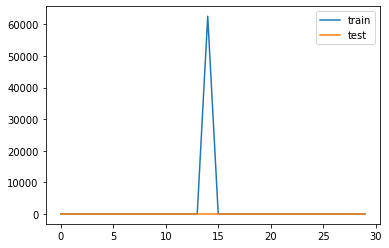

12/12 [==============================] - 1s 28ms/step


(2849, 4)


Observed     Predicted           Coin               Model  \
Date                                                                        
2021-06-30  35040.835938  35423.324219  BTC - Bitcoin  Deep Learning LSTM   
2021-07-01  33572.117188  35100.597656  BTC - Bitcoin  Deep Learning LSTM   
2021-07-02  33897.046875  33827.933594  BTC - Bitcoin  Deep Learning LSTM   
2021-07-03  34668.546875  33600.839844  BTC - Bitcoin  Deep Learning LSTM   
2021-07-04  35287.781250  34122.050781  BTC - Bitcoin  Deep Learning LSTM   
...                  ...           ...            ...                 ...   
2022-06-24  21231.656250  19175.044922  BTC - Bitcoin  Deep Learning LSTM   
2022-06-25  21502.337891  19443.521484  BTC - Bitcoin  Deep Learning LSTM   
2022-06-26  21027.294922  19489.646484  BTC - Bitcoin  Deep Learning LSTM   
2022-06-27  20735.478516  19085.466797  BTC - Bitcoin  Deep Learning LSTM   
2022-06-28  20280.634766  19427.224609  BTC - Bitcoin  Deep Learning LSTM   

                  Scope  
Date                     
2021-06-30  1 day ahead  
2021-07-01  1 day ahead  
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [10]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=100, 
                                                                        dense_units=100, 
                                                                        drop=False,
                                                                        drop_rate=0.1,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=15,
                                                                    save=True
                                                                )
lstm_tdf = gen_test_df(
    lstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
lstm_tdf_filtered = lstm_tdf[['Observed', 'Predicted']]
plot_model_test(lstm_tdf_filtered).show()
lstm_idf = gen_importance_df(lstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(lstm_idf).show()
lstm_tdf

## BLSTM

Epoch 1/50
2424/2424 - 62s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0247 - val_mse: 0.0247 - 62s/epoch - 26ms/step
Epoch 2/50
2424/2424 - 59s - loss: 7.5643e-04 - mse: 7.5643e-04 - val_loss: 0.0053 - val_mse: 0.0053 - 59s/epoch - 24ms/step
Epoch 3/50
2424/2424 - 58s - loss: 6.6590e-04 - mse: 6.6590e-04 - val_loss: 0.0020 - val_mse: 0.0020 - 58s/epoch - 24ms/step
Epoch 4/50
2424/2424 - 60s - loss: 5.2870e-04 - mse: 5.2870e-04 - val_loss: 0.0022 - val_mse: 0.0022 - 60s/epoch - 25ms/step
Epoch 5/50
2424/2424 - 58s - loss: 4.8802e-04 - mse: 4.8802e-04 - val_loss: 0.0016 - val_mse: 0.0016 - 58s/epoch - 24ms/step
Epoch 6/50
2424/2424 - 58s - loss: 3.5596e-04 - mse: 3.5596e-04 - val_loss: 0.0026 - val_mse: 0.0026 - 58s/epoch - 24ms/step
Epoch 7/50
2424/2424 - 59s - loss: 3.4282e-04 - mse: 3.4282e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 59s/epoch - 24ms/step
Epoch 8/50
2424/2424 - 58s - loss: 3.1293e-04 - mse: 3.1293e-04 - val_loss: 0.0035 - val_mse: 0.0035 - 58s/epoch - 24ms/step
Epoch 9/

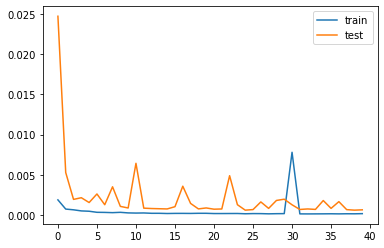

12/12 [==============================] - 1s 11ms/step


(2849, 4)


Observed     Predicted           Coin               Model  \
Date                                                                        
2021-06-30  35040.835938  35525.246094  BTC - Bitcoin  Bidirectional LSTM   
2021-07-01  33572.117188  35695.621094  BTC - Bitcoin  Bidirectional LSTM   
2021-07-02  33897.046875  35071.472656  BTC - Bitcoin  Bidirectional LSTM   
2021-07-03  34668.546875  34891.898438  BTC - Bitcoin  Bidirectional LSTM   
2021-07-04  35287.781250  35259.773438  BTC - Bitcoin  Bidirectional LSTM   
...                  ...           ...            ...                 ...   
2022-06-24  21231.656250  20579.185547  BTC - Bitcoin  Bidirectional LSTM   
2022-06-25  21502.337891  20825.486328  BTC - Bitcoin  Bidirectional LSTM   
2022-06-26  21027.294922  21079.244141  BTC - Bitcoin  Bidirectional LSTM   
2022-06-27  20735.478516  21088.947266  BTC - Bitcoin  Bidirectional LSTM   
2022-06-28  20280.634766  21223.876953  BTC - Bitcoin  Bidirectional LSTM   

                  Scope  
Date                     
2021-06-30  1 day ahead  
2021-07-01  1 day ahead  
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [12]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=False,
                                                                        drop_rate=0.5
                                                                    ),
                                                                    n_epochs=50,
                                                                    early_stop=True,
                                                                    patience=30,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf_filtered = blstm_tdf[['Observed', 'Predicted']]
plot_model_test(blstm_tdf_filtered).show()
blstm_idf = gen_importance_df(blstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(blstm_idf).show()
blstm_tdf

In [ ]:
preds_df = pd.concat([lstm_tdf, blstm_tdf])
preds_df.to_csv('./models/predictions.csv', index=True)

imp_df = pd.concat([lstm_idf, blstm_idf])
imp_df.to_csv('./models/ft_importance.csv', index=False)

## Attentive BLSTM

In [ ]:
""" model_id = 'Attentive Bidirectional LSTM'
ablstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_AttentiveBLSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=32,
                                                                        drop=False, 
                                                                        drop_rate=0.5,
                                                                        suffix='5RNN_d50'
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10    
                                                                )
ablstm_tdf = gen_test_df(
    ablstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker='BTC', 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
ablstm_tdf_filtered = filter_test_df(
    ablstm_tdf, 
    'BTC', 
    model_id, 
    scope
    )
plot_model_test(ablstm_tdf_filtered).show()
ablstm_idf = gen_importance_df(
    ablstm_model, 
    dsets['BTC-USD'], 
    timesteps, 
    'BTC', 
    model_id, 
    scope
    )
plot_importance(ablstm_idf) """

## Explainable Forecast

We use LIME methodology to make our deep learning models more interpretable. Here, we get the most relevant features at different time steps and their contributions for a single sample prediction. Below, we get the top 10 features contributing to the final prediction for a recent date. This will let us understand the most relevant factors and their influence on the price at different points of time.

**EXPLICAR MEJOR LIME!!**

In [ ]:
%%capture
%pip install lime

We get the lime estimate of feature contribution to the cryptocurrency price for each one of the test samples, giving us the top 10 features and their direct effect on the forecast. Thus, making the model explainable across time.

In [20]:
def get_lime_df(model, model_id, X_train, X_test, dsets, test_dates, coin_name, scope, yscaler):

    explainer = lime.lime_tabular.RecurrentTabularExplainer(
                                            X_train,
                                            feature_names=list(dsets[ticker + '-USD'].columns),
                                            verbose=True,
                                            mode='regression',
                                            discretize_continuous=False
                                            )

    lime_dfs = []
    for i in range(len(test_dates)):
        exp = explainer.explain_instance(X_test[i], model.predict)
        lime_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'LIME Weight'])
        lime_df['Predicted Close t+'+scope[0]] = yscaler.inverse_transform(lime_df['LIME Weight'].abs().values.reshape(-1,1))[:,0] * (lime_df['LIME Weight'].values//lime_df['LIME Weight'].abs().values)
        lime_df['Date'] = test_dates[i]
        lime_df['Model'] = model_id
        lime_df['Coin'] = coin_name
        lime_df['Scope'] = scope
        lime_dfs.append(lime_df)
    lime_df = pd.concat(lime_dfs)
    lime_df['LIME Weight'] = yscaler.inverse_transform(lime_df['LIME Weight'].values.reshape(-1,1))
    lime_df.rename(columns={'Date': 'Date_dt'}, inplace=True)
    lime_df['Date'] = lime_df['Date_dt'].dt.date.apply(lambda x: str(x))
    return lime_df

def plot_lime(lime_df):

    fig = px.bar(
        lime_df, 
        x='LIME Weight', 
        y='Feature',
        animation_frame='Date',
        orientation='h', 
        color='LIME Weight', 
        template='plotly_dark',
        title="LIME - Top Features' Effect on Close t+1",
        color_continuous_scale='viridis',
        )
    fig.update_layout(
            xaxis_tickformat = '$',
            title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(
                #family="Courier New, monospace",
                size=25)
                },
            )
    fig.update_traces(
        hovertemplate="<br>".join([
            "Feature: %{y}",
            "Contribution: $%{x:,.2f}"])
            )

    fig.show()
    return fig

In [ ]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM',X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)
lime_all = pd.concat([lstm_ldf, blstm_ldf])
lime_all.to_csv('./models/lime.csv', index=False)

# ETH - Ethereum

#### Prepare Data and Take a look at Selected Features

In [10]:
cc = 'ETH-USD'
timesteps = 60
coin_name = 'ETH - Ethereum'
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1522, 60, 5) (1522,) (120, 60, 5) (120,)


In [11]:
dsets[cc]

Volume     Gtrend    FVX           BTC        Close
Date                                                                
2017-11-09    893249984  26.000000  2.003   7143.580078   320.884003
2017-11-10    885985984  22.000000  2.055   6618.140137   299.252991
2017-11-11    842300992  19.000000  2.055   6357.600098   314.681000
2017-11-12   1613479936  20.000000  2.055   5950.069824   307.907990
2017-11-13   1041889984  20.000000  2.072   6559.490234   316.716003
...                 ...        ...    ...           ...          ...
2022-06-24  16981552654  46.000000  3.175  21231.656250  1226.844727
2022-06-25  12481946184  42.000000  3.175  21502.337891  1243.446899
2022-06-26  12096607824  40.000000  3.175  21027.294922  1199.831665
2022-06-27  12492225250  82.208333  3.258  20735.478516  1193.680664
2022-06-28  14023205651  75.541667  3.260  20280.634766  1144.579224

[1702 rows x 5 columns]

## LSTM

Epoch 1/30
1522/1522 - 33s - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0022 - val_mse: 0.0022 - 33s/epoch - 22ms/step
Epoch 2/30
1522/1522 - 31s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0014 - val_mse: 0.0014 - 31s/epoch - 20ms/step
Epoch 3/30
1522/1522 - 31s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0026 - val_mse: 0.0026 - 31s/epoch - 21ms/step
Epoch 4/30
1522/1522 - 31s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011 - 31s/epoch - 21ms/step
Epoch 5/30
1522/1522 - 32s - loss: 0.0013 - mse: 0.0013 - val_loss: 7.6597e-04 - val_mse: 7.6597e-04 - 32s/epoch - 21ms/step
Epoch 6/30
1522/1522 - 33s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0022 - val_mse: 0.0022 - 33s/epoch - 22ms/step
Epoch 7/30
1522/1522 - 32s - loss: 9.5927e-04 - mse: 9.5927e-04 - val_loss: 9.4528e-04 - val_mse: 9.4528e-04 - 32s/epoch - 21ms/step
Epoch 8/30
1522/1522 - 31s - loss: 6.8842e-04 - mse: 6.8842e-04 - val_loss: 8.1206e-04 - val_mse: 8.1206e-04 - 31s/epoch - 20ms/step
Epoch 9/30
1522/1522 - 3

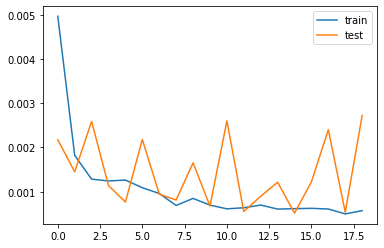

4/4 [==============================] - 0s 27ms/step


(1702, 5)


Observed    Predicted            Coin               Model  \
Date                                                                       
2022-03-01  2972.485107  2806.008789  ETH - Ethereum  Deep Learning LSTM   
2022-03-02  2950.118408  2926.770264  ETH - Ethereum  Deep Learning LSTM   
2022-03-03  2834.468994  2983.241943  ETH - Ethereum  Deep Learning LSTM   
2022-03-04  2617.156006  2964.310059  ETH - Ethereum  Deep Learning LSTM   
2022-03-05  2664.831055  2861.012451  ETH - Ethereum  Deep Learning LSTM   
...                 ...          ...             ...                 ...   
2022-06-24  1226.844727  1209.343994  ETH - Ethereum  Deep Learning LSTM   
2022-06-25  1243.446899  1221.931396  ETH - Ethereum  Deep Learning LSTM   
2022-06-26  1199.831665  1242.316406  ETH - Ethereum  Deep Learning LSTM   
2022-06-27  1193.680664  1257.813232  ETH - Ethereum  Deep Learning LSTM   
2022-06-28  1144.579224  1288.094238  ETH - Ethereum  Deep Learning LSTM   

                  Scope  
Date                     
2022-03-01  1 day ahead  
2022-03-02  1 day ahead  
2022-03-03  1 day ahead  
2022-03-04  1 day ahead  
2022-03-05  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[120 rows x 5 columns]

In [15]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=128, 
                                                                        dense_units=100, 
                                                                        drop=False, 
                                                                        drop_rate=0.3,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=15,
                                                                    save=True
                                                                )
lstm_tdf = gen_test_df(
    lstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
lstm_tdf_filtered = lstm_tdf[['Observed', 'Predicted']]
plot_model_test(lstm_tdf_filtered).show()
lstm_idf = gen_importance_df(lstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(lstm_idf).show()
lstm_tdf

## BLSTM

Epoch 1/100
1522/1522 - 38s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0064 - val_mse: 0.0064 - 38s/epoch - 25ms/step
Epoch 2/100
1522/1522 - 34s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0055 - val_mse: 0.0055 - 34s/epoch - 23ms/step
Epoch 3/100
1522/1522 - 34s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0080 - val_mse: 0.0080 - 34s/epoch - 22ms/step
Epoch 4/100
1522/1522 - 34s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0039 - val_mse: 0.0039 - 34s/epoch - 22ms/step
Epoch 5/100
1522/1522 - 35s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0030 - val_mse: 0.0030 - 35s/epoch - 23ms/step
Epoch 6/100
1522/1522 - 34s - loss: 9.1514e-04 - mse: 9.1514e-04 - val_loss: 0.0031 - val_mse: 0.0031 - 34s/epoch - 23ms/step
Epoch 7/100
1522/1522 - 34s - loss: 7.7475e-04 - mse: 7.7475e-04 - val_loss: 0.0032 - val_mse: 0.0032 - 34s/epoch - 23ms/step
Epoch 8/100
1522/1522 - 34s - loss: 7.6056e-04 - mse: 7.6056e-04 - val_loss: 0.0029 - val_mse: 0.0029 - 34s/epoch - 22ms/step
Epoch 9/100
1522/1522 - 34s - lo

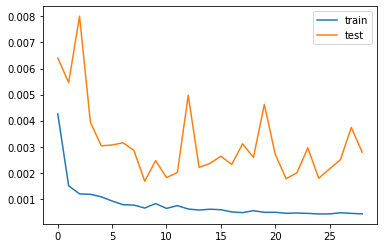

4/4 [==============================] - 1s 14ms/step


(1702, 5)


Observed    Predicted            Coin               Model  \
Date                                                                       
2022-03-01  2972.485107  2831.663330  ETH - Ethereum  Bidirectional LSTM   
2022-03-02  2950.118408  2913.070557  ETH - Ethereum  Bidirectional LSTM   
2022-03-03  2834.468994  2912.190674  ETH - Ethereum  Bidirectional LSTM   
2022-03-04  2617.156006  2897.148193  ETH - Ethereum  Bidirectional LSTM   
2022-03-05  2664.831055  2804.139648  ETH - Ethereum  Bidirectional LSTM   
...                 ...          ...             ...                 ...   
2022-06-24  1226.844727  1253.103516  ETH - Ethereum  Bidirectional LSTM   
2022-06-25  1243.446899  1270.745850  ETH - Ethereum  Bidirectional LSTM   
2022-06-26  1199.831665  1312.516724  ETH - Ethereum  Bidirectional LSTM   
2022-06-27  1193.680664  1315.678223  ETH - Ethereum  Bidirectional LSTM   
2022-06-28  1144.579224  1298.750610  ETH - Ethereum  Bidirectional LSTM   

                  Scope  
Date                     
2022-03-01  1 day ahead  
2022-03-02  1 day ahead  
2022-03-03  1 day ahead  
2022-03-04  1 day ahead  
2022-03-05  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[120 rows x 5 columns]

In [16]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=32, 
                                                                        dense_units=50, 
                                                                        drop=False,
                                                                        drop_rate=0.5
                                                                    ),
                                                                    n_epochs=100,
                                                                    early_stop=True,
                                                                    patience=20,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf_filtered = blstm_tdf[['Observed', 'Predicted']]
plot_model_test(blstm_tdf_filtered).show()
blstm_idf = gen_importance_df(blstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(blstm_idf).show()
blstm_tdf

### LIME Explainable

In [21]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM',X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)
lime_all = pd.concat([lstm_ldf, blstm_ldf])
lime_all.to_csv('./models/lime.csv', index=False)

157/157 [==============================] - 4s 27ms/step
Intercept 0.190694206312114
Prediction_local [0.5010786]
Right: 0.5756827
157/157 [==============================] - 4s 27ms/step
Intercept 0.19026856132427974
Prediction_local [0.51487895]
Right: 0.6012257
157/157 [==============================] - 4s 27ms/step
Intercept 0.19084421085696032
Prediction_local [0.52382016]
Right: 0.6131703
157/157 [==============================] - 5s 29ms/step
Intercept 0.19083979988357305
Prediction_local [0.52959237]
Right: 0.6091659
157/157 [==============================] - 4s 28ms/step
Intercept 0.19088291522187095
Prediction_local [0.52508881]
Right: 0.5873168
157/157 [==============================] - 4s 27ms/step
Intercept 0.19042121494256445
Prediction_local [0.51138032]
Right: 0.5721483
157/157 [==============================] - 5s 29ms/step
Intercept 0.1909994100355729
Prediction_local [0.50301903]
Right: 0.5564361
157/157 [==============================] - 5s 32ms/step
Intercept 0.18970

In [19]:
#preds_df = pd.read_csv('./models/predictions.csv', parse_dates=['Date'], index_col='Date')
preds_df = pd.concat([lstm_tdf, blstm_tdf])
preds_df.to_csv('./models/predictions.csv', index=True)

#imp_df = pd.readcsv('./models/ft_importance.csv')
imp_df = pd.concat([lstm_idf, blstm_idf])
imp_df.to_csv('./models/ft_importance.csv', index=False)

# LTC - Litecoin

In [22]:
cc = 'LTC-USD'
timesteps = 60
coin_name = 'LTC - Litecoin'
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2438, 60, 5) (2438,) (365, 60, 5) (365,)


## LSTM

Epoch 1/30
2438/2438 - 53s - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0046 - val_mse: 0.0046 - 53s/epoch - 22ms/step
Epoch 2/30
2438/2438 - 53s - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0034 - val_mse: 0.0034 - 53s/epoch - 22ms/step
Epoch 3/30
2438/2438 - 50s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0035 - val_mse: 0.0035 - 50s/epoch - 21ms/step
Epoch 4/30
2438/2438 - 50s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0051 - val_mse: 0.0051 - 50s/epoch - 21ms/step
Epoch 5/30
2438/2438 - 50s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0038 - val_mse: 0.0038 - 50s/epoch - 21ms/step
Epoch 6/30
2438/2438 - 50s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0088 - val_mse: 0.0088 - 50s/epoch - 21ms/step
Epoch 7/30
2438/2438 - 51s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0026 - val_mse: 0.0026 - 51s/epoch - 21ms/step
Epoch 8/30
2438/2438 - 51s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0023 - val_mse: 0.0023 - 51s/epoch - 21ms/step
Epoch 9/30
2438/2438 - 50s - loss: 0.0014 - mse: 0.0014 - val_lo

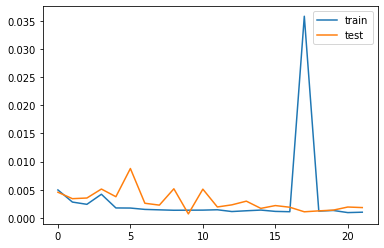

12/12 [==============================] - 1s 28ms/step


(2863, 5)


Observed   Predicted            Coin               Model  \
Date                                                                     
2021-07-02  136.943695  141.733063  LTC - Litecoin  Deep Learning LSTM   
2021-07-03  140.279694  140.710373  LTC - Litecoin  Deep Learning LSTM   
2021-07-04  144.905853  140.120102  LTC - Litecoin  Deep Learning LSTM   
2021-07-05  138.073242  141.622070  LTC - Litecoin  Deep Learning LSTM   
2021-07-06  138.985641  141.069962  LTC - Litecoin  Deep Learning LSTM   
...                ...         ...             ...                 ...   
2022-06-24   55.992283   52.242199  LTC - Litecoin  Deep Learning LSTM   
2022-06-25   58.969929   52.481968  LTC - Litecoin  Deep Learning LSTM   
2022-06-26   56.876144   53.158028  LTC - Litecoin  Deep Learning LSTM   
2022-06-27   55.925556   53.716175  LTC - Litecoin  Deep Learning LSTM   
2022-06-28   52.811611   55.242737  LTC - Litecoin  Deep Learning LSTM   

                  Scope  
Date                     
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
2021-07-05  1 day ahead  
2021-07-06  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [23]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=128, 
                                                                        dense_units=100, 
                                                                        drop=True, 
                                                                        drop_rate=0.3,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=12,
                                                                    save=True
                                                                )
lstm_tdf = gen_test_df(
    lstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
lstm_tdf_filtered = lstm_tdf[['Observed', 'Predicted']]
plot_model_test(lstm_tdf_filtered).show()
lstm_idf = gen_importance_df(lstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(lstm_idf).show()
lstm_tdf

## BLSTM

Epoch 1/30
2438/2438 - 63s - loss: 21.5955 - mse: 21.5955 - val_loss: 0.0019 - val_mse: 0.0019 - 63s/epoch - 26ms/step
Epoch 2/30
2438/2438 - 58s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0018 - val_mse: 0.0018 - 58s/epoch - 24ms/step
Epoch 3/30
2438/2438 - 58s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0054 - val_mse: 0.0054 - 58s/epoch - 24ms/step
Epoch 4/30
2438/2438 - 59s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0074 - val_mse: 0.0074 - 59s/epoch - 24ms/step
Epoch 5/30
2438/2438 - 59s - loss: 2676.8386 - mse: 2676.8386 - val_loss: 0.0053 - val_mse: 0.0053 - 59s/epoch - 24ms/step
Epoch 6/30
2438/2438 - 59s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0070 - val_mse: 0.0070 - 59s/epoch - 24ms/step
Epoch 7/30
2438/2438 - 60s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0051 - val_mse: 0.0051 - 60s/epoch - 24ms/step
Epoch 8/30
2438/2438 - 60s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0062 - val_mse: 0.0062 - 60s/epoch - 24ms/step
Epoch 9/30
2438/2438 - 59s - loss: 9.7351e-04 - mse: 9.7

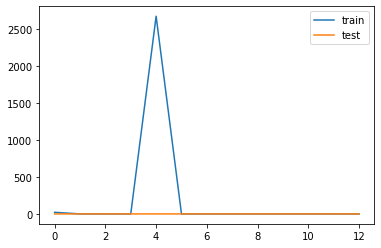

12/12 [==============================] - 1s 11ms/step


(2863, 5)


Observed   Predicted            Coin               Model  \
Date                                                                     
2021-07-02  136.943695  170.131424  LTC - Litecoin  Bidirectional LSTM   
2021-07-03  140.279694  170.158752  LTC - Litecoin  Bidirectional LSTM   
2021-07-04  144.905853  170.329117  LTC - Litecoin  Bidirectional LSTM   
2021-07-05  138.073242  170.583145  LTC - Litecoin  Bidirectional LSTM   
2021-07-06  138.985641  169.974075  LTC - Litecoin  Bidirectional LSTM   
...                ...         ...             ...                 ...   
2022-06-24   55.992283   66.671577  LTC - Litecoin  Bidirectional LSTM   
2022-06-25   58.969929   66.197556  LTC - Litecoin  Bidirectional LSTM   
2022-06-26   56.876144   65.616776  LTC - Litecoin  Bidirectional LSTM   
2022-06-27   55.925556   64.821083  LTC - Litecoin  Bidirectional LSTM   
2022-06-28   52.811611   63.545456  LTC - Litecoin  Bidirectional LSTM   

                  Scope  
Date                     
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
2021-07-05  1 day ahead  
2021-07-06  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [24]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=12,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf_filtered = blstm_tdf[['Observed', 'Predicted']]
plot_model_test(blstm_tdf_filtered).show()
blstm_idf = gen_importance_df(blstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(blstm_idf).show()
blstm_tdf

In [26]:
preds_df = pd.read_csv('./models/predictions.csv', parse_dates=['Date'], index_col='Date')
preds_df = pd.concat([preds_df, lstm_tdf, blstm_tdf])
preds_df.to_csv('./models/predictions.csv', index=True)

imp_df = pd.read_csv('./models/ft_importance.csv')
imp_df = pd.concat([imp_df, lstm_idf, blstm_idf])
imp_df.to_csv('./models/ft_importance.csv', index=False)

## Interpretable Models with LIME

In [32]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM',X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)
lime_all = pd.read_csv('./models/lime.csv',)
lime_all = pd.concat([lime_all, lstm_ldf, blstm_ldf])
lime_all.to_csv('./models/lime.csv', index=False)

157/157 [==============================] - 6s 38ms/step
Intercept 0.09818911659351635
Prediction_local [0.2824465]
Right: 0.36485422
157/157 [==============================] - 6s 38ms/step
Intercept 0.09825667047702188
Prediction_local [0.27796261]
Right: 0.3621999
157/157 [==============================] - 6s 39ms/step
Intercept 0.097619607645592
Prediction_local [0.27509683]
Right: 0.36066788
157/157 [==============================] - 6s 39ms/step
Intercept 0.09789178815480361
Prediction_local [0.27609937]
Right: 0.36456612
157/157 [==============================] - 6s 39ms/step
Intercept 0.09766988102772434
Prediction_local [0.27637225]
Right: 0.36313316
157/157 [==============================] - 6s 39ms/step
Intercept 0.09749107816520447
Prediction_local [0.26975943]
Right: 0.36062682
157/157 [==============================] - 6s 40ms/step
Intercept 0.09696670126224687
Prediction_local [0.26798386]
Right: 0.35716254
157/157 [==============================] - 6s 38ms/step
Intercept 

# NMC - NameCoin

In [33]:
cc = 'NMC-USD'
timesteps = 60
scope = '1 day ahead'
coin_name = 'NMC - Namecoin'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
dsets[cc]

(2438, 60, 5) (2438,) (365, 60, 5) (365,)


Volume     Gtrend    FVX           BTC     Close
Date                                                        
2014-09-17  466593  34.000000  1.804    457.334015  1.264560
2014-09-18  486429  17.000000  1.841    424.440002  1.229760
2014-09-19  179233   0.000000  1.819    394.795990  1.104190
2014-09-20  128440  20.000000  1.819    408.903992  1.194410
2014-09-21   92990  59.000000  1.819    398.821014  1.110980
...            ...        ...    ...           ...       ...
2022-06-24    7464   0.000000  3.175  21231.656250  1.361111
2022-06-25    7429  31.000000  3.175  21502.337891  1.405799
2022-06-26    5899   0.000000  3.175  21027.294922  1.390472
2022-06-27    7369  21.041667  3.258  20735.478516  1.358410
2022-06-28    7238  21.166667  3.260  20280.634766  1.303938

[2863 rows x 5 columns]

## LSTM

Epoch 1/30
2438/2438 - 55s - loss: 0.0041 - mse: 0.0041 - val_loss: 8.8231e-04 - val_mse: 8.8231e-04 - 55s/epoch - 23ms/step
Epoch 2/30
2438/2438 - 53s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0034 - val_mse: 0.0034 - 53s/epoch - 22ms/step
Epoch 3/30
2438/2438 - 53s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016 - 53s/epoch - 22ms/step
Epoch 4/30
2438/2438 - 54s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0029 - val_mse: 0.0029 - 54s/epoch - 22ms/step
Epoch 5/30
2438/2438 - 53s - loss: 0.0014 - mse: 0.0014 - val_loss: 5.8075e-04 - val_mse: 5.8075e-04 - 53s/epoch - 22ms/step
Epoch 6/30
2438/2438 - 52s - loss: 0.0014 - mse: 0.0014 - val_loss: 7.4736e-04 - val_mse: 7.4736e-04 - 52s/epoch - 21ms/step
Epoch 7/30
2438/2438 - 52s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0047 - val_mse: 0.0047 - 52s/epoch - 21ms/step
Epoch 8/30
2438/2438 - 52s - loss: 0.0013 - mse: 0.0013 - val_loss: 8.2528e-04 - val_mse: 8.2528e-04 - 52s/epoch - 22ms/step
Epoch 9/30
2438/2438 - 52s - los

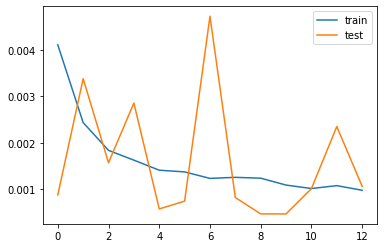

12/12 [==============================] - 1s 39ms/step


(2863, 5)


Observed  Predicted            Coin               Model  \
Date                                                                  
2021-07-02  1.340603   1.332700  NMC - Namecoin  Deep Learning LSTM   
2021-07-03  1.381137   1.358230  NMC - Namecoin  Deep Learning LSTM   
2021-07-04  1.317293   1.379764  NMC - Namecoin  Deep Learning LSTM   
2021-07-05  1.333834   1.395611  NMC - Namecoin  Deep Learning LSTM   
2021-07-06  1.340912   1.421976  NMC - Namecoin  Deep Learning LSTM   
...              ...        ...             ...                 ...   
2022-06-24  1.361111   1.306270  NMC - Namecoin  Deep Learning LSTM   
2022-06-25  1.405799   1.282219  NMC - Namecoin  Deep Learning LSTM   
2022-06-26  1.390472   1.282062  NMC - Namecoin  Deep Learning LSTM   
2022-06-27  1.358410   1.281960  NMC - Namecoin  Deep Learning LSTM   
2022-06-28  1.303938   1.291306  NMC - Namecoin  Deep Learning LSTM   

                  Scope  
Date                     
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
2021-07-05  1 day ahead  
2021-07-06  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [34]:
model_id = 'Deep Learning LSTM'
lstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_LSTM,
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=128, 
                                                                        dense_units=100, 
                                                                        drop=True, 
                                                                        drop_rate=0.3,
                                                                    ),
                                                                    batch_size=1,
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=12,
                                                                    save=True
                                                                )
lstm_tdf = gen_test_df(
    lstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
lstm_tdf_filtered = lstm_tdf[['Observed', 'Predicted']]
plot_model_test(lstm_tdf_filtered).show()
lstm_idf = gen_importance_df(lstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(lstm_idf).show()
lstm_tdf

## BLSTM

Epoch 1/30
2438/2438 - 62s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0019 - val_mse: 0.0019 - 62s/epoch - 25ms/step
Epoch 2/30
2438/2438 - 58s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0012 - val_mse: 0.0012 - 58s/epoch - 24ms/step
Epoch 3/30
2438/2438 - 59s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0023 - val_mse: 0.0023 - 59s/epoch - 24ms/step
Epoch 4/30
2438/2438 - 59s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0015 - val_mse: 0.0015 - 59s/epoch - 24ms/step
Epoch 5/30
2438/2438 - 59s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014 - 59s/epoch - 24ms/step
Epoch 6/30
2438/2438 - 59s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0014 - val_mse: 0.0014 - 59s/epoch - 24ms/step
Epoch 7/30
2438/2438 - 59s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015 - 59s/epoch - 24ms/step
Epoch 8/30
2438/2438 - 59s - loss: 0.0010 - mse: 0.0010 - val_loss: 8.7828e-04 - val_mse: 8.7828e-04 - 59s/epoch - 24ms/step
Epoch 9/30
2438/2438 - 60s - loss: 9.5560e-04 - mse: 9.5

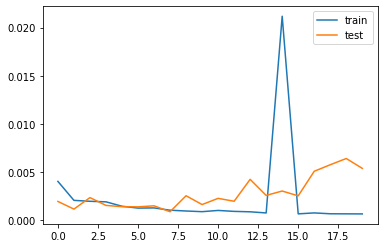

12/12 [==============================] - 1s 14ms/step


(2863, 5)


Observed  Predicted            Coin               Model  \
Date                                                                  
2021-07-02  1.340603   1.541796  NMC - Namecoin  Bidirectional LSTM   
2021-07-03  1.381137   1.560434  NMC - Namecoin  Bidirectional LSTM   
2021-07-04  1.317293   1.564274  NMC - Namecoin  Bidirectional LSTM   
2021-07-05  1.333834   1.565589  NMC - Namecoin  Bidirectional LSTM   
2021-07-06  1.340912   1.574157  NMC - Namecoin  Bidirectional LSTM   
...              ...        ...             ...                 ...   
2022-06-24  1.361111   1.498319  NMC - Namecoin  Bidirectional LSTM   
2022-06-25  1.405799   1.517640  NMC - Namecoin  Bidirectional LSTM   
2022-06-26  1.390472   1.565363  NMC - Namecoin  Bidirectional LSTM   
2022-06-27  1.358410   1.574940  NMC - Namecoin  Bidirectional LSTM   
2022-06-28  1.303938   1.594820  NMC - Namecoin  Bidirectional LSTM   

                  Scope  
Date                     
2021-07-02  1 day ahead  
2021-07-03  1 day ahead  
2021-07-04  1 day ahead  
2021-07-05  1 day ahead  
2021-07-06  1 day ahead  
...                 ...  
2022-06-24  1 day ahead  
2022-06-25  1 day ahead  
2022-06-26  1 day ahead  
2022-06-27  1 day ahead  
2022-06-28  1 day ahead  

[365 rows x 5 columns]

In [35]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=12,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    coin_name=coin_name, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf_filtered = blstm_tdf[['Observed', 'Predicted']]
plot_model_test(blstm_tdf_filtered).show()
blstm_idf = gen_importance_df(blstm_model, dsets[cc], timesteps, ticker, model_id, scope)
plot_importance(blstm_idf).show()
blstm_tdf

In [36]:
preds_df = pd.read_csv('./models/predictions.csv', parse_dates=['Date'], index_col='Date')
preds_df = pd.concat([preds_df, lstm_tdf, blstm_tdf])
preds_df.to_csv('./models/predictions.csv', index=True)

imp_df = pd.read_csv('./models/ft_importance.csv')
imp_df = pd.concat([imp_df, lstm_idf, blstm_idf])
imp_df.to_csv('./models/ft_importance.csv', index=False)

In [37]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM',X_train, X_test, dsets, test_dates, coin_name, scope, yscaler)
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)
lime_all = pd.read_csv('./models/lime.csv',)
lime_all = pd.concat([lime_all, lstm_ldf, blstm_ldf])
lime_all.to_csv('./models/lime.csv', index=False)

157/157 [==============================] - 7s 42ms/step
Intercept 0.06476523623693496
Prediction_local [0.09989634]
Right: 0.16239753
157/157 [==============================] - 7s 43ms/step
Intercept 0.06495808101787526
Prediction_local [0.10371375]
Right: 0.16596162
157/157 [==============================] - 7s 43ms/step
Intercept 0.06474443787023872
Prediction_local [0.1053037]
Right: 0.16896796
157/157 [==============================] - 7s 46ms/step
Intercept 0.0650484831878668
Prediction_local [0.09977793]
Right: 0.17118016
157/157 [==============================] - 7s 45ms/step
Intercept 0.0647997266939429
Prediction_local [0.10182064]
Right: 0.17486094
157/157 [==============================] - 6s 41ms/step
Intercept 0.06493942156400347
Prediction_local [0.09869283]
Right: 0.17577428
157/157 [==============================] - 6s 41ms/step
Intercept 0.06511461238096784
Prediction_local [0.10182289]
Right: 0.17664829
157/157 [==============================] - 7s 42ms/step
Intercept

# PPC - 

In [ ]:
cc = 'PPC-USD'
timesteps = 60
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
dsets[cc]

In [ ]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    ticker, 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets[cc], 
    timesteps, 
    ticker, 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

In [ ]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    ticker, 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets[cc], 
    timesteps, 
    ticker, 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

In [ ]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
pd.concat([lstm_ldf, blstm_ldf]).to_csv('./models/other_tested/{}_lime.csv'.format(ticker), index=False)
pd.concat([lstm_idf, blstm_idf]).to_csv('./models/other_tested/{}_fimp.csv'.format(ticker), index=False)
pd.concat([lstm_tdf, blstm_tdf]).to_csv('./models/other_tested/{}_preds.csv'.format(ticker))
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)

# FTC - FeatherCoin

In [ ]:
cc = 'FTC-USD'
timesteps = 60
scope = '1 day ahead'
ticker = cc[:3]
X_train, y_train, X_test, y_test, xscaler, yscaler, test_dates = prep_dsets[cc]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
dsets[cc]

In [ ]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    ticker, 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets[cc], 
    timesteps, 
    ticker, 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

In [ ]:
model_id = 'Bidirectional LSTM'
blstm_model, X_test, y_test, xscaler, yscaler, test_dates = train_model(
                                                                    prep_dsets=prep_dsets, 
                                                                    coin_name=cc, 
                                                                    model_builder=build_BLSTM, 
                                                                    model_kwargs=dict(
                                                                        num_rnns=2,
                                                                        dim_rnn=16, 
                                                                        dense_units=50, 
                                                                        drop=True,
                                                                        drop_rate=0.3
                                                                    ),
                                                                    n_epochs=30,
                                                                    early_stop=True,
                                                                    patience=10,
                                                                    save=True
                                                                )
blstm_tdf = gen_test_df(
    blstm_model, 
    X_test, 
    y_test, 
    yscaler, 
    ticker=ticker, 
    test_dates=test_dates, 
    lags=timesteps, 
    model_id=model_id, 
    pred_scope=scope
    )
blstm_tdf = filter_test_df(
    blstm_tdf, 
    ticker, 
    model_id, 
    scope
    )
plot_model_test(blstm_tdf).show()
blstm_idf = gen_importance_df(
    blstm_model, 
    dsets[cc], 
    timesteps, 
    ticker, 
    model_id, 
    scope
    )
plot_importance(blstm_idf)

In [ ]:
lstm_ldf = get_lime_df(lstm_model, 'Deep Learning LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
blstm_ldf = get_lime_df(blstm_model, 'Bidirectional LSTM', X_train, X_test, dsets, test_dates, ticker, scope, yscaler)
pd.concat([lstm_ldf, blstm_ldf]).to_csv('./models/other_tested/{}_lime.csv'.format(ticker), index=False)
pd.concat([lstm_idf, blstm_idf]).to_csv('./models/other_tested/{}_fimp.csv'.format(ticker), index=False)
pd.concat([lstm_tdf, blstm_tdf]).to_csv('./models/other_tested/{}_preds.csv'.format(ticker))
plot_lime(lstm_ldf)
plot_lime(blstm_ldf)

In [26]:
import pandas as pd
import sqlite3 as sql
conn = sql.connect('database.db', detect_types=sql.PARSE_DECLTYPES)
fi_npro = pd.read_csv('./models/nprophet_ft_importance.csv', parse_dates=['Date_dt'])
fi_npro.drop(columns=[c for c in fi_npro.columns.to_list() if 'Unnamed' in c], inplace=True)
fi_npro = fi_npro.query('Feature != "residual1"')
fi_npro

Date    Date_dt        Feature  ...  Ticker           Model        Scope
365    2021-06-29 2021-06-29            ar1  ...     BTC  Neural Prophet  1 day ahead
366    2021-06-30 2021-06-30            ar1  ...     BTC  Neural Prophet  1 day ahead
367    2021-07-01 2021-07-01            ar1  ...     BTC  Neural Prophet  1 day ahead
368    2021-07-02 2021-07-02            ar1  ...     BTC  Neural Prophet  1 day ahead
369    2021-07-03 2021-07-03            ar1  ...     BTC  Neural Prophet  1 day ahead
...           ...        ...            ...  ...     ...             ...          ...
13610  2022-06-24 2022-06-24  season_weekly  ...     FTC  Neural Prophet  1 day ahead
13611  2022-06-25 2022-06-25  season_weekly  ...     FTC  Neural Prophet  1 day ahead
13612  2022-06-26 2022-06-26  season_weekly  ...     FTC  Neural Prophet  1 day ahead
13613  2022-06-27 2022-06-27  season_weekly  ...     FTC  Neural Prophet  1 day ahead
13614  2022-06-28 2022-06-28  season_weekly  ...     FTC  Neural Prophet  1 day ahead

[11670 rows x 7 columns]

In [12]:
preddf = pd.read_csv('./models/predictions.csv', parse_dates=['Date'], index_col='Date').drop_duplicates().reset_index()
preddf

Date      Observed     Predicted            Coin  \
0    2022-03-01   2972.485107   2806.008800  ETH - Ethereum   
1    2022-03-02   2950.118408   2926.770300  ETH - Ethereum   
2    2022-03-03   2834.468994   2983.242000  ETH - Ethereum   
3    2022-03-04   2617.156006   2964.310000  ETH - Ethereum   
4    2022-03-05   2664.831055   2861.012500  ETH - Ethereum   
...         ...           ...           ...             ...   
2425 2022-06-24  21231.656250  19175.044922   BTC - Bitcoin   
2426 2022-06-25  21502.337891  19443.521484   BTC - Bitcoin   
2427 2022-06-26  21027.294922  19489.646484   BTC - Bitcoin   
2428 2022-06-27  20735.478516  19085.466797   BTC - Bitcoin   
2429 2022-06-28  20280.634766  19427.224609   BTC - Bitcoin   

                   Model        Scope  
0     Deep Learning LSTM  1 day ahead  
1     Deep Learning LSTM  1 day ahead  
2     Deep Learning LSTM  1 day ahead  
3     Deep Learning LSTM  1 day ahead  
4     Deep Learning LSTM  1 day ahead  
...                  ...          ...  
2425  Deep Learning LSTM  1 day ahead  
2426  Deep Learning LSTM  1 day ahead  
2427  Deep Learning LSTM  1 day ahead  
2428  Deep Learning LSTM  1 day ahead  
2429  Deep Learning LSTM  1 day ahead  

[2430 rows x 6 columns]

In [128]:
pd.read_csv('./presel_coins.csv')

index    id                     name  symbol               slug  rank  \
0       0     1                  Bitcoin     BTC            bitcoin     1   
1     151  1027                 Ethereum     ETH           ethereum     2   
2     121   825                   Tether    USDT             tether     3   
3      18    52                      XRP     XRP                xrp     8   
4      27    74                 Dogecoin    DOGE           dogecoin    10   
5       1     2                 Litecoin     LTC           litecoin    18   
6      91   512                  Stellar     XLM            stellar    24   
7      72   328                   Monero     XMR             monero    29   
8      40   131                     Dash    DASH               dash    70   
9     128   873                      NEM     XEM                nem    83   
10    157  1042                  Siacoin      SC            siacoin   120   
11     36   109                 DigiByte     DGB           digibyte   143   
12     92   541                  Syscoin     SYS            syscoin   191   
13    167  1104                    Augur     REP              augur   194   
14     66   291             MaidSafeCoin    MAID       maidsafecoin   282   
15     62   268                WhiteCoin     XWC          whitecoin   362   
16    107   693                    Verge     XVG              verge   364   
17     54   213                 MonaCoin    MONA           monacoin   444   
18    127   859                 Woodcoin     LOG           woodcoin   463   
19     59   258              Groestlcoin     GRS        groestlcoin   492   
20     86   463                BitShares     BTS          bitshares   493   
21    116   788        Circuits of Value   COVAL  circuits-of-value   534   
22      2     3                 Namecoin     NMC           namecoin   575   
23     37   118                 ReddCoin     RDD               redd   682   
24     80   372                 Bytecoin     BCN       bytecoin-bcn   722   
25     14    41             Infinitecoin     IFC       infinitecoin   753   
26     35    99                 Vertcoin     VTC           vertcoin   763   
27    117   789                    Nexus     NXS              nexus   770   
28      4     5                 Peercoin     PPC           peercoin   786   
29     41   132             Counterparty     XCP       counterparty   820   
30    155  1037  Agoras: Currency of Tau    AGRS      agoras-tokens   830   
31     28    77                  Diamond     DMD            diamond   840   
32    169  1107             PAC Protocol     PAC       pac-protocol   878   
33     81   377                  Navcoin     NAV           nav-coin   903   
34    101   624                   bitCNY  BITCNY             bitcny   941   
35     96   576              GameCredits    GAME        gamecredits  1017   
36     89   502               Carboncoin  CARBON         carboncoin  1035   
37     23    66                      Nxt     NXT                nxt  1052   
38    165  1087                   Factom     FCT             factom  1078   
39    163  1082                  SIBCoin     SIB            sibcoin  1156   
40     52   201              Einsteinium    EMC2        einsteinium  1160   
41     77   362                CloakCoin   CLOAK          cloakcoin  1212   
42     31    83                     Omni    OMNI               omni  1237   
43     33    90                 Dimecoin    DIME           dimecoin  1243   
44    123   833                 Gridcoin     GRC           gridcoin  1249   
45    152  1032             TransferCoin      TX       transfercoin  1251   
46     34    93                  42-coin      42            42-coin  1264   
47      6     8              Feathercoin     FTC        feathercoin  1266   
48    110   707                 Blocknet   BLOCK           blocknet  1275   
49     58   254                   Gulden     NLG             gulden  1294   

    is_active        days_history hash_symbol           hash_slug  \
0      

In [29]:
pred_npro = pd.read_csv('./models/nprophet_predictions.csv', parse_dates=['Date'])
pred_npro.drop(columns=[c for c in pred_npro.columns.to_list() if 'Unnamed' in c], inplace=True)
pred_npro.replace({'Ticker': coins_dict}, inplace=True)
pred_npro.rename(columns={'Ticker': 'Coin'}, inplace=True)
pred_npro

Date      Observed     Predicted               Coin  \
0    2021-06-29  35867.777344  34411.640625      BTC - Bitcoin   
1    2021-06-30  35040.835938  35880.324219      BTC - Bitcoin   
2    2021-07-01  33572.117188  35018.492188      BTC - Bitcoin   
3    2021-07-02  33897.046875  33565.492188      BTC - Bitcoin   
4    2021-07-03  34668.546875  33909.777344      BTC - Bitcoin   
...         ...           ...           ...                ...   
1940 2022-06-24      0.006876      0.006738  FTC - Feathercoin   
1941 2022-06-25      0.007064      0.007816  FTC - Feathercoin   
1942 2022-06-26      0.006922      0.007370  FTC - Feathercoin   
1943 2022-06-27      0.006246      0.007543  FTC - Feathercoin   
1944 2022-06-28      0.006173      0.006386  FTC - Feathercoin   

               Model        Scope  
0     Neural Prophet  1 day ahead  
1     Neural Prophet  1 day ahead  
2     Neural Prophet  1 day ahead  
3     Neural Prophet  1 day ahead  
4     Neural Prophet  1 day ahead  
...              ...          ...  
1940  Neural Prophet  1 day ahead  
1941  Neural Prophet  1 day ahead  
1942  Neural Prophet  1 day ahead  
1943  Neural Prophet  1 day ahead  
1944  Neural Prophet  1 day ahead  

[1945 rows x 6 columns]

In [30]:
preddf = pd.read_csv('./models/predictions.csv', parse_dates=['Date'], index_col='Date').drop_duplicates().reset_index()
preddf = pd.concat([preddf, pred_npro])
preddf

Date     Observed    Predicted               Coin  \
0    2022-03-01  2972.485107  2806.008800     ETH - Ethereum   
1    2022-03-02  2950.118408  2926.770300     ETH - Ethereum   
2    2022-03-03  2834.468994  2983.242000     ETH - Ethereum   
3    2022-03-04  2617.156006  2964.310000     ETH - Ethereum   
4    2022-03-05  2664.831055  2861.012500     ETH - Ethereum   
...         ...          ...          ...                ...   
1940 2022-06-24     0.006876     0.006738  FTC - Feathercoin   
1941 2022-06-25     0.007064     0.007816  FTC - Feathercoin   
1942 2022-06-26     0.006922     0.007370  FTC - Feathercoin   
1943 2022-06-27     0.006246     0.007543  FTC - Feathercoin   
1944 2022-06-28     0.006173     0.006386  FTC - Feathercoin   

                   Model        Scope  
0     Deep Learning LSTM  1 day ahead  
1     Deep Learning LSTM  1 day ahead  
2     Deep Learning LSTM  1 day ahead  
3     Deep Learning LSTM  1 day ahead  
4     Deep Learning LSTM  1 day ahead  
...                  ...          ...  
1940      Neural Prophet  1 day ahead  
1941      Neural Prophet  1 day ahead  
1942      Neural Prophet  1 day ahead  
1943      Neural Prophet  1 day ahead  
1944      Neural Prophet  1 day ahead  

[4375 rows x 6 columns]

# Text Sentiment

In [126]:
from app.api import Twitter

twt = Twitter()
tweets = twt.get_tweets_df(query='crypto OR Bitcoin OR Ethereum OR Litecoin OR Blockchain', limit=500, ticker='ALL', popular=True)

In [102]:
%%capture
%pip install wordcloud

In [127]:
tweets.drop_duplicates(subset=['full_text'])

id                      created_at  \
0   1544727945390039042  Wed Jul 06 17:00:16 +0000 2022   
1   1544356249965416450  Tue Jul 05 16:23:17 +0000 2022   
2   1544788337415921666  Wed Jul 06 21:00:15 +0000 2022   
3   1544263173221453825  Tue Jul 05 10:13:26 +0000 2022   
4   1544471882673659904  Wed Jul 06 00:02:46 +0000 2022   
..                  ...                             ...   
67  1541362506962276355  Mon Jun 27 10:07:13 +0000 2022   
68  1541361701509013510  Mon Jun 27 10:04:01 +0000 2022   
69  1541363658970009600  Mon Jun 27 10:11:48 +0000 2022   
70  1541367505104412672  Mon Jun 27 10:27:05 +0000 2022   
71  1541364043801305088  Mon Jun 27 10:13:19 +0000 2022   

                                            full_text  truncated  retweets  \
0   Giveaway three is officially unlocked: It’s $5...      False      9690   
1   I will send $1,000 to someone that has retweet...      False      9204   
2   Happy $50,000 in bitcoin. That’s what we’re gi...      False      5611   
3   $50 in 4 hours ⏳⚡🌫⛅\n\n-RT + Follow @Genius_Cr...      False     10706   
4   Africa is primed for crypto adoption. 10-20% b...      False      2940   
..                                                ...        ...       ...   
67  Which #Crypto project should I buy on my birth...      False       125   
68  Presenting the BIS #AnnualEconReport, Agustín ...      False        45   
69  @TorchesFinance has now launched on #KCC 🎉🎉🎉\n...      False        39   
70  The Chinese media continue to warn the public ...      False        21   
71  The wipeout in Bitcoin may have run its course...      False        24   

          user_name  user_verified  user_followers  \
0           CashApp           True         1872728   
1   OfficialTravlad           True          314648   
2           CashApp           True         1872728   
3      GiveAwayHost           True          379448   
4        cz_binance           True         6575364   
..              ...            ...             ...   
67          Ralvero           True          104112   
68          BIS_org           True          135632   
69    KCCOfficialTW           True           84052   
70    Cointelegraph           True         1748618   
71           crypto           True          924926   

                                       user_image_url ticker  
0   http://pbs.twimg.com/profile_images/9714949199...    ALL  
1   http://pbs.twimg.com/profile_images/1544757475...    ALL  
2   http://pbs.twimg.com/profile_images/9714949199...    ALL  
3   http://pbs.twimg.com/profile_images/1532339589...    ALL  
4   http://pbs.twimg.com/profile_images/1520776623...    ALL  
..                                                ...    ...  
67  http://pbs.twimg.com/profile_images/1511048566...    ALL  
68  http://pbs.twimg.com/profile_images/1542750920...    ALL  
69  http://pbs.twimg.com/profile_images/1390868645...    ALL  
70  http://pbs.twimg.com/profile_images/1270073276...    ALL  
71  http://pbs.twimg.com/profile_images/1483830321...    ALL  

[72 rows x 10 columns]

C:\Users\Priscilla\AppData\Local\Temp\ipykernel_14264\3741799297.py:34: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



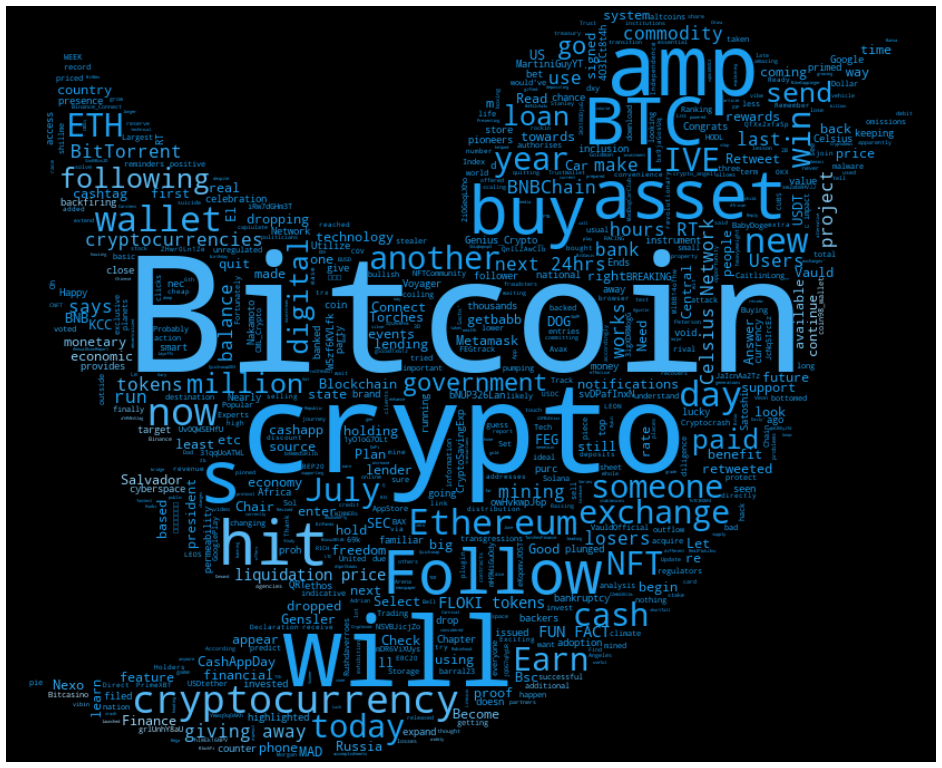

In [123]:
import matplotlib.pyplot      as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path
import random
from scipy.ndimage import gaussian_gradient_magnitude

def plot_wordcloud(text_df, path_to_logo, text_col='full_text', max_words=800, width=750, height=750):
    
    df2 = text_df.dropna(subset=[text_col], axis = 0)[text_col].copy()
    text = " ".join(s for s in df2)
    stopwords = set(STOPWORDS)
    stopwords.update(['t', 'https', 'co'])
    fura_color = np.array(Image.open(os.path.join(path_to_logo)))
    wordcloud = WordCloud(
            stopwords=stopwords,
            background_color="black",
            width=width, 
            height=height, 
            max_words=max_words,
            mask=fura_color,
            max_font_size=150,
            min_font_size=1).generate(text)
    # ploting it in a specific image
    image_colors = ImageColorGenerator(fura_color)

    # show
    fig, ax = plt.subplots(figsize=(20,20), dpi=60)
    ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    ax.set_axis_off()
    return fig

plot_wordcloud(tweets, './sentiment_models/twt_logo.png').show()


In [4]:
from app.api import Twitter
twt = Twitter()
twt.get_tweets_df('BTC', 'Bitcoin', 1)

id  ... ticker
0  1544356249965416450  ...    BTC

[1 rows x 10 columns]

In [6]:
import pandas as pd
twt = Twitter()
coins_df = pd.read_csv('./presel_coins.csv')
tweets_dfs = []
for ticker in coins_df['symbol'].unique():
    q = coins_df[coins_df['symbol']==ticker]['twt_query'].values[0]
    ticker_tweets = twt.get_tweets_df(query=q, limit=20, ticker=ticker)
    if ticker_tweets.shape[0] > 0:
        tweets_dfs.append(ticker_tweets)
tweets_df = pd.concat(tweets_dfs)
tweets_df.to_csv('tweets_all.csv', index=False)
tweets_df

id  ... ticker
0   1544356249965416450  ...    BTC
1   1544727945390039042  ...    BTC
2   1544788337415921666  ...    BTC
3   1544851409786482689  ...    BTC
4   1544851406615728133  ...    BTC
..                  ...  ...    ...
15  1544832564799672326  ...    NLG
16  1544831186354245633  ...    NLG
17  1544828504184954880  ...    NLG
18  1544828105411309568  ...    NLG
19  1544825833340018691  ...    NLG

[966 rows x 10 columns]

In [53]:
def plot_twt_wordcloud(text_df, sentiment='all', text_col='full_text', max_words=800, width=400, height=400, news=False):

    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import os
    from os import path
    import random
    from scipy.ndimage import gaussian_gradient_magnitude
    
    if sentiment == 'positive':
        path_to_logo = './sentiment_models/twt_green.png'
    elif sentiment == 'negative':
        path_to_logo = './sentiment_models/twt_red.png'
    else:
        if news:
            path_to_logo = './sentiment_models/news_neutral_logo.png'
        else:
            path_to_logo = './sentiment_models/news_neutral_logo.png'

    df2 = text_df.dropna(subset=[text_col], axis = 0)[text_col].copy()
    text = " ".join(s for s in df2)
    stopwords = set(STOPWORDS)
    stopwords.update(['t', 'https', 'co', 'rt', 'RT', 'AMP', 'amp', 'u', 'one', 's', 'S'])
    fura_color = np.array(Image.open(os.path.join(path_to_logo)))
    wordcloud = WordCloud(
            stopwords=stopwords,
            background_color="white",
            width=width, 
            height=height, 
            max_words=max_words,
            mask=fura_color,
            max_font_size=100,
            min_font_size=5).generate(text)
    # ploting it in a specific image
    image_colors = ImageColorGenerator(fura_color)

    # show
    fig, ax = plt.subplots(figsize=(15,15), dpi=60)
    ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    ax.set_axis_off()
    if news:
        img_path =  './app/dashboard/assets/news_wcloud_' + sentiment + '.png'
    else:
        img_path = './app/dashboard/assets/wcloud_' + sentiment + '.png'
    wordcloud.to_file(img_path)
    
    return 'wcloud_' + sentiment + '.png'

#plot_twt_wordcloud(tweets_df.query('Sentiment=="negative"'), sentiment='negative')

In [2]:
import requests
import json

import pandas as pd
from app.modules import Sentiment_predict

url = "https://crypto-news-today.p.rapidapi.com/news/bitcoin"

querystring = {"start_date":"2020-01-01","end_date":"2022-07-04"}

headers = {
	"X-RapidAPI-Key": "bac7b05363msh253acbf8dccfba1p1da097jsn86335e8c73a8",
	"X-RapidAPI-Host": "crypto-news-today.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)
resp_json = json.loads(json.dumps(response.text))
resp_dict = json.loads(resp_json)
news_dict = resp_dict['news']
btc_news = pd.DataFrame.from_records(news_dict)
btc_news['created_at'] = pd.to_datetime(btc_news['created_at'])
btc_news = btc_news.sort_values(['created_at'], ascending=False).drop_duplicates(subset=['title'])
btc_news.info()
btc_news.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 390 to 0
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        390 non-null    object             
 1   keyword      390 non-null    object             
 2   url          390 non-null    object             
 3   source_name  390 non-null    object             
 4   source_url   390 non-null    object             
 5   created_at   390 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 21.3+ KB


title  ...                created_at
390  Bitcoin nears full supply with 19 million coin...  ... 2022-04-01 07:00:00+00:00
389  Bitcoin Slides for Second Day as Analyst Warns...  ... 2022-03-31 07:00:00+00:00
388  Why the rise of a Bitcoin standard could deter...  ... 2022-03-30 07:00:00+00:00
387  Watch: How Bitcoin is Fueling the Climate Cris...  ... 2022-03-29 07:00:00+00:00
386  MicroStrategy subsidiary will purchase Bitcoin...  ... 2022-03-29 07:00:00+00:00

[5 rows x 6 columns]

In [4]:
sp = Sentiment_predict()
sp.sentiment_finBERT(btc_news, 'title')

KeyError: 'cleantitle'

In [56]:
news = pd.read_csv('./sentiment_models/polygon_df_01_07_2022.csv', parse_dates=['published_utc'])
news

id  ... description_FinancialBERT
0     a7gHdwIF1lvqc9BIRXp7yHrLwXLyqNgaFB35FZUdg6A  ...                  positive
1     -SLkdTRNPDjhsuRtMmroZRL80bXA2pqVHYkUnuNycbQ  ...                   neutral
2     NzZ2IzUTw77copseebzV8cl7SqRoBL75OX9CZbl69Qc  ...                   neutral
3     DClrCFOp-iQivQ7TriSnOtcLnhGH3q2NLfT0XI7ocL8  ...                   neutral
4     ZcjbMZnVlxd5pI8LoCQQYjys1CfkbnUBb12FwsoIFQA  ...                  negative
...                                           ...  ...                       ...
2173  FyA4ZkwlrVine2bABJvDwBd6IbUcjZCEtL-PifFRa9U  ...                  negative
2174  L_ZhaO7RnSRpN3GH38voMPl8CYXZ74sfDgFkjWiKzsk  ...                  negative
2175  TcShePRfF3rc_er7upYMQ8RHQhRq5H8p4gG4rnckx0g  ...                       NaN
2176  4ew8u1Xy43ccKA4EbjHhF_L7HIn0hwwu1QpCUriMXSA  ...                       NaN
2177  F3sb6rrFeLV0AVOae83jpTFIJDlaPIwsmchrRSpGIc0  ...                       NaN

[2178 rows x 13 columns]

In [61]:
import plotly.express as px

news_coin = news[['description_FinBERT', 'tickers']]
news_coin['BTC'] = news.tickers.str.count("BTC")
news_coin['ETH'] = news.tickers.str.count("ETH")
news_coin['LTC'] = news.tickers.str.count("LTC")
news_coin['NMC'] = news.tickers.str.count("NMC")
news_coin.drop(columns=['tickers'], inplace=True)

px.bar(
    news_coin,
    x=['BTC', 'ETH', 'LTC', 'NMC'],
    y='description_FinBERT'
)

C:\Users\Priscilla\AppData\Local\Temp\ipykernel_40012\369118505.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Priscilla\AppData\Local\Temp\ipykernel_40012\369118505.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Priscilla\AppData\Local\Temp\ipykernel_40012\369118505.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

'wcloud_all.png'

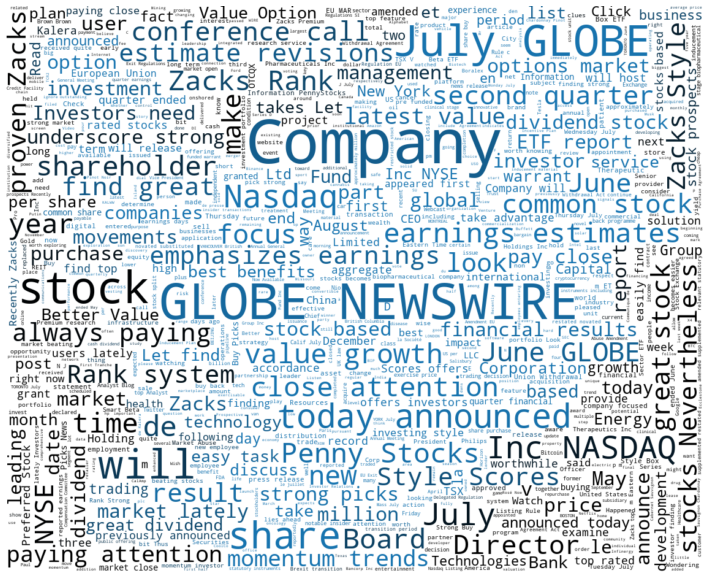

In [57]:
plot_twt_wordcloud(news.query('description_FinBERT=="neutral"'), text_col='description', sentiment='all', news=True)

In [44]:
news['description_FinBERT'].value_counts()

neutral     1026
positive     738
negative     362
Name: description_FinBERT, dtype: int64

In [45]:
news['description_FinancialBERT'].value_counts()

neutral     1075
positive     846
negative     205
Name: description_FinancialBERT, dtype: int64

In [66]:
btc_news['date'] = btc_news['created_at'].dt.date
daynews = btc_news[['date', 'title']].groupby(['date']).count()

title
date             
2020-01-02      1
2020-01-08      1
2020-01-14      1
2020-01-18      1
2020-01-22      1
...           ...
2022-03-27      1
2022-03-29      1
2022-03-30      1
2022-03-31      1
2022-04-01      1

[271 rows x 1 columns]

# Other Plots

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Compute Error Metrics

In [60]:
mae = preddf.groupby(['Coin', 'Model', 'Scope']).apply(lambda x: mean_absolute_error(x['Observed'], x['Predicted'])).reset_index().rename(columns={0: 'MAE'})
mape = preddf.groupby(['Coin', 'Model', 'Scope']).apply(lambda x: mean_absolute_percentage_error(x['Observed'], x['Predicted'])).reset_index().rename(columns={'0': 'MAPE'})
mse = mae = preddf.groupby(['Coin', 'Model', 'Scope']).apply(lambda x: mean_squared_error(x['Observed'], x['Predicted'])).reset_index().rename(columns={'0': 'MSE'})
mae = mae.rename(columns={0: 'MAE'})
mape = mape.rename(columns={0: 'MAPE'})
mse = mse.rename(columns={0: 'MSE'})
mse['RMSE'] = np.sqrt(mse['MSE'])
err_table = mae.merge(mape, how='left', on=['Coin', 'Model', 'Scope'])
err_table = err_table.merge(mse, how='left', on=['Coin', 'Model', 'Scope'])
err_table = pd.melt(
    err_table, 
    value_vars=['MAE', 'MAPE', 'MSE', 'RMSE'], 
    id_vars=['Coin', 'Model', 'Scope'], 
    var_name='Metric', 
    value_name='Error'
    )
err_table.head()

Coin               Model        Scope Metric         Error
0   BTC - Bitcoin  Bidirectional LSTM  1 day ahead    MAE  4.053127e+06
1   BTC - Bitcoin  Deep Learning LSTM  1 day ahead    MAE  4.230133e+06
2   BTC - Bitcoin      Neural Prophet  1 day ahead    MAE  2.256392e+06
3  ETH - Ethereum  Bidirectional LSTM  1 day ahead    MAE  3.745148e+04
4  ETH - Ethereum  Deep Learning LSTM  1 day ahead    MAE  2.542818e+04

In [87]:
import plotly.express as px

def error_bars(coin_label, metric='MAE'):

    conn = sql.connect('database.db', detect_types=sql.PARSE_DECLTYPES)
    db_query = """
        SELECT * 
        FROM error_metrics
        WHERE Coin = "{}"
            AND Metric = "{}"
    """.format(coin_label, metric)

    err_table = pd.read_sql(
        db_query,
        conn
    )
    fig = px.bar(
        err_table,
        x="Metric", 
        y="Error",
        color="Model", 
        barmode="group",
        template='plotly_white'
        )
    if metric in ['MAE', 'MSE', 'RMSE']:  
        fig.update_layout(yaxis_tickformat = '$')
    else:
        fig.update_layout(axis_tickformat = '%')
    return fig

In [89]:
error_bars("BTC - Bitcoin", metric='MAPE').show()

In [20]:
from app.modules import Sentiment_predict

sp = Sentiment_predict()
tweets_df = pd.read_csv('tweets_all.csv', parse_dates=['created_at'])
tweets_ws = sp.sentiment_finBERT(tweets_df, 'full_text')
tweets_ws

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutr

In [28]:
tweets_df['Sentiment'] = tweets_ws
tweets_df['Sentiment'].value_counts()
import pandas as pd
import sqlite3 as sql
conn = sql.connect('database.db', detect_types=sql.PARSE_DECLTYPES)
tweets_df.to_sql('tweets', conn, index=False, if_exists='replace')

In [31]:
tweets_df.to_csv('tweets_all.csv', index=False)